In [123]:
import collections
import pickle
import torch
from tqdm import tqdm
import wandb

api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["mst"]}},
                     {"config.subset": "35"},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}"
    if unique_name in archives:
        continue
        
    #print(unique_name)
    #for file in run.files():
    #    if file.name == 'results.pkl':
    #        file.download(replace=True)
            
    #with open('results.pkl', 'rb') as f:
    #    results = pickle.load(f)
    if 'corrs_report' in run.summary:
        for file in run.files():
            if file.name == 'results.pkl':
                file.download(replace=True)
            if file.name == 'optimal_weights.pkl':
                file.download(replace=True)
                
        with open('results.pkl', 'rb') as f:
            results = pickle.load(f)
            
        with open('optimal_weights.pkl', 'rb') as f:
            optimal_weights = pickle.load(f)
            
        archives[unique_name] = {'corrs_report': run.summary['corrs_report'],
                                 'config': run.config,
                                 'results': results,
                                 'optimal_weights': optimal_weights}

  0%|          | 0/47 [00:00<?, ?it/s]

Found 47


100%|██████████| 47/47 [00:45<00:00,  1.03it/s]


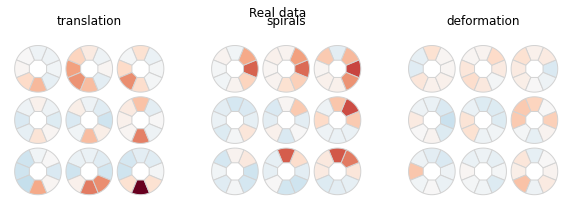

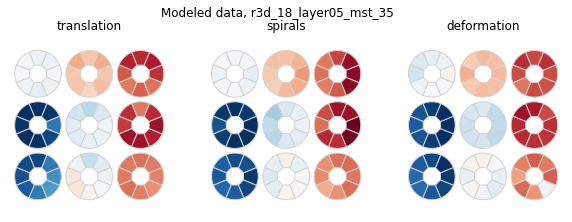

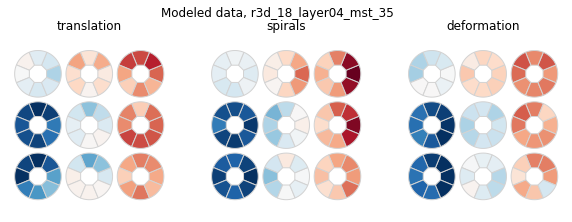

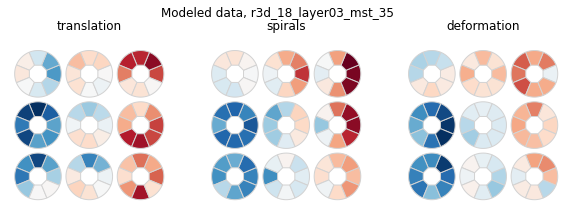

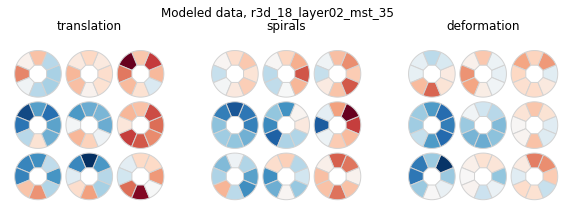

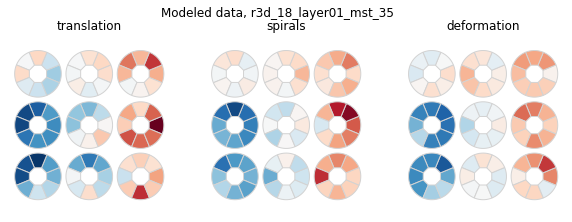

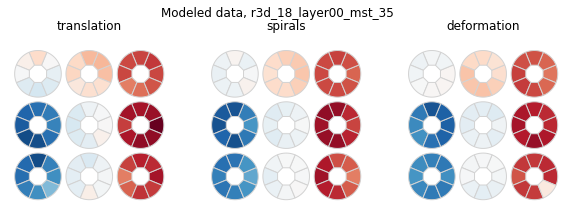

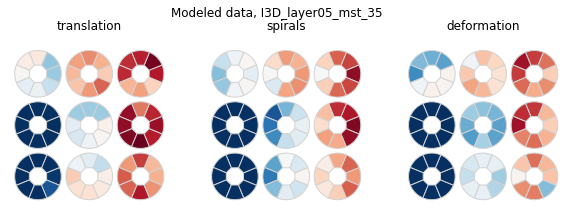

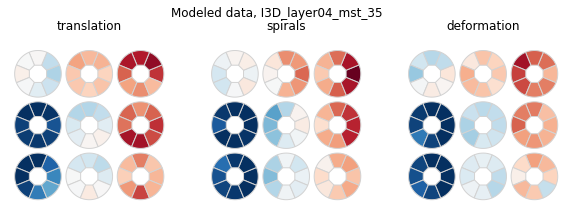

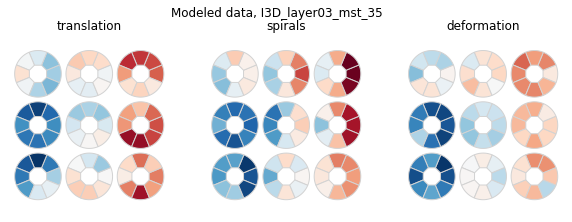

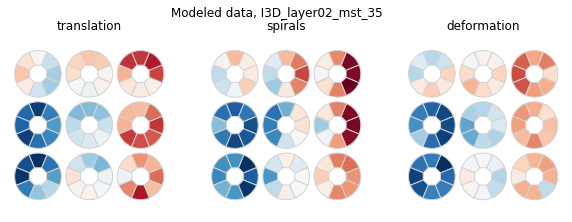

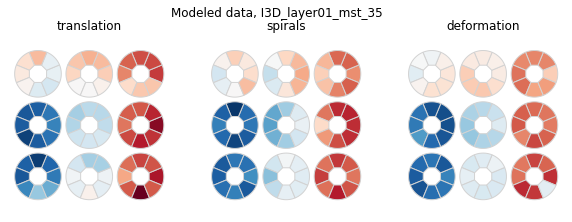

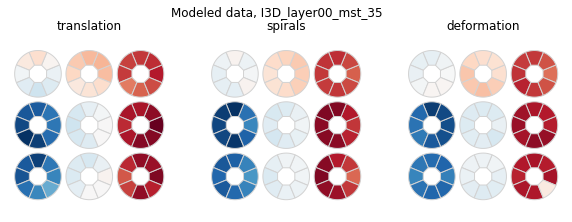

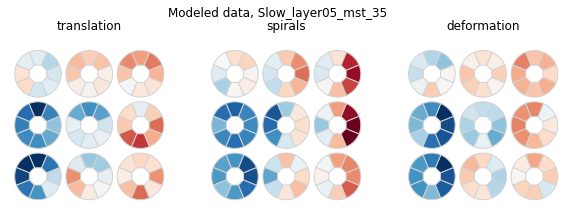

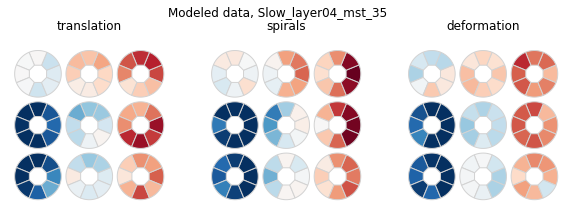

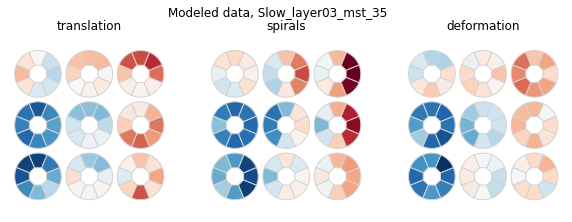

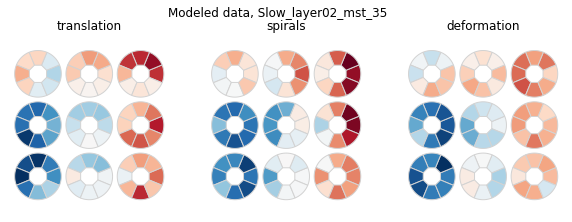

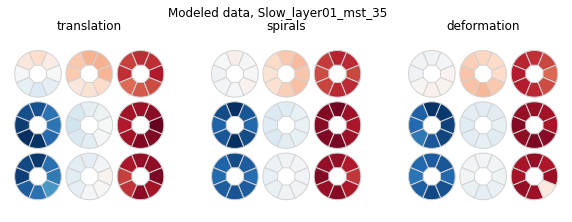

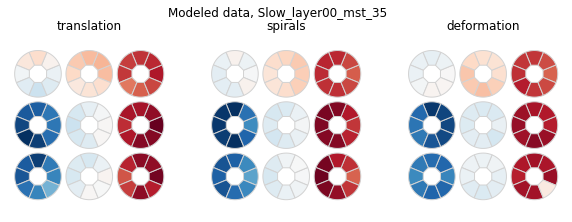

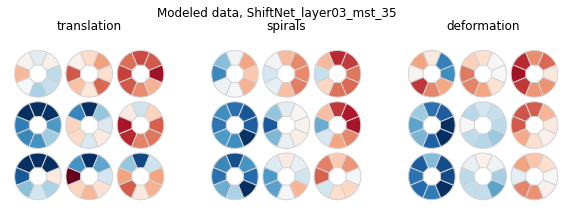

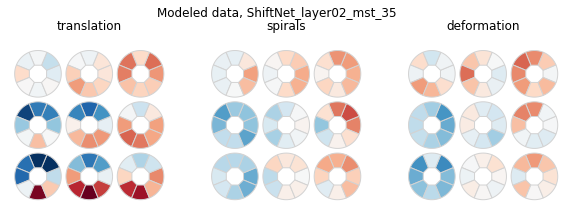

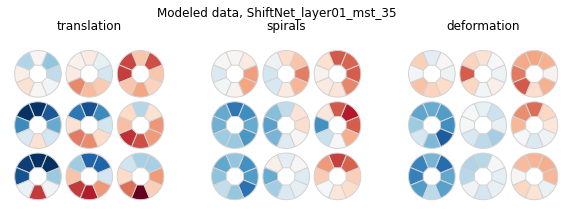

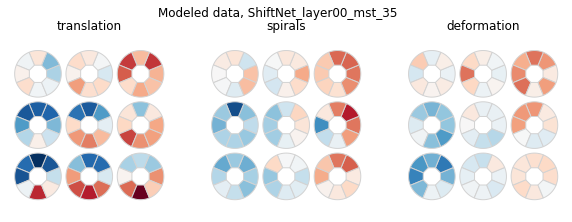

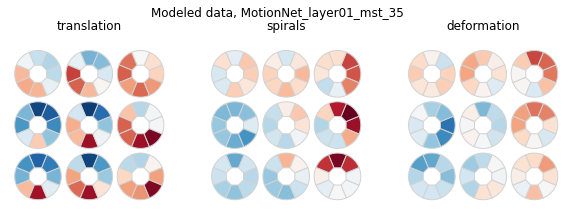

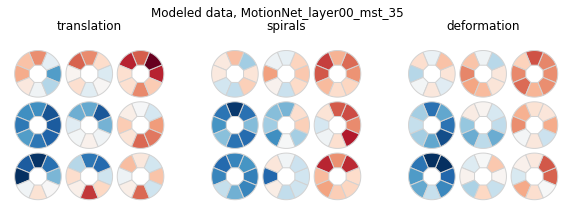

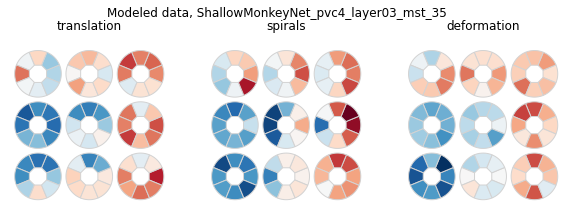

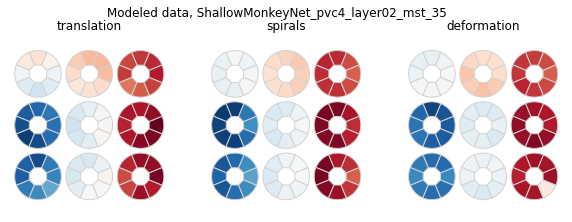

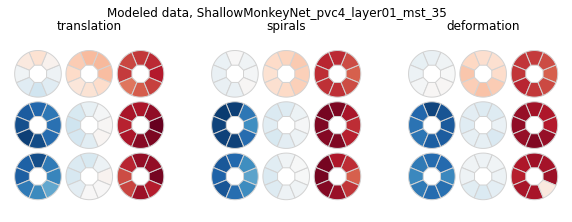

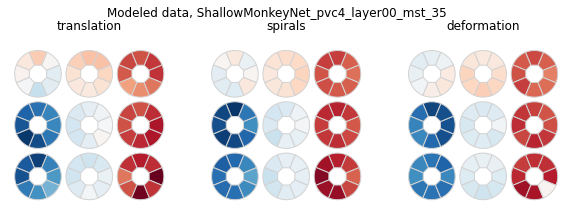

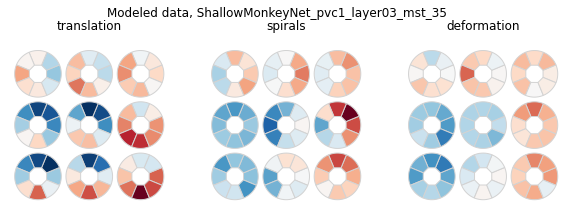

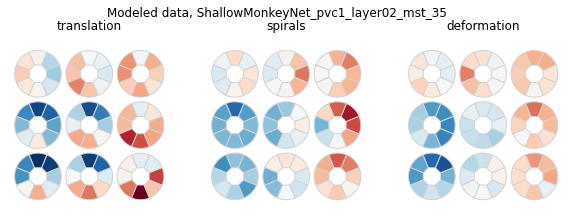

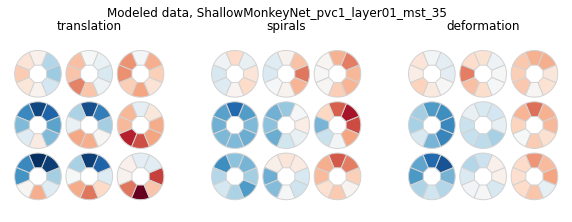

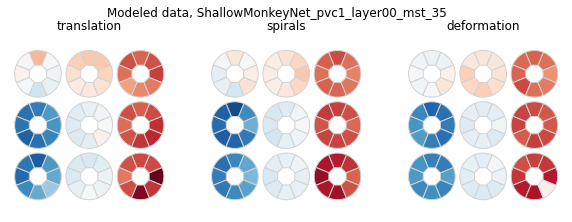

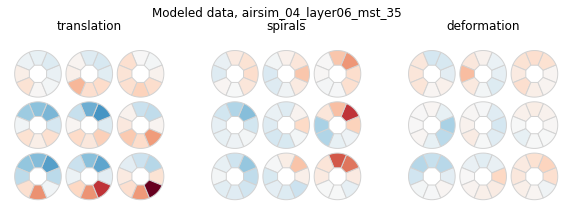

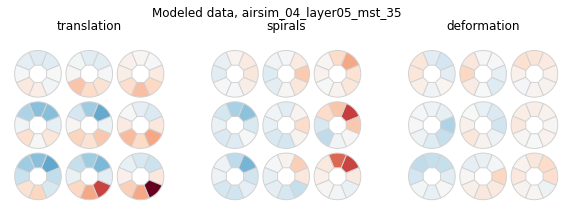

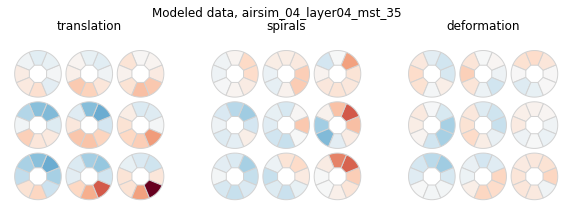

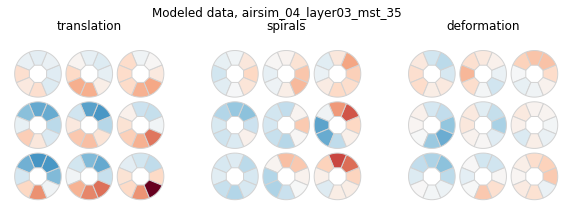

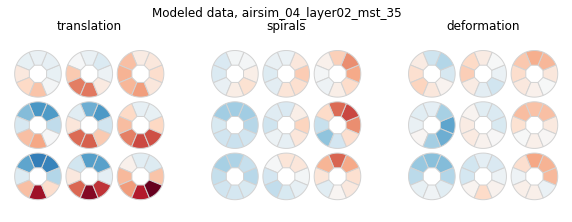

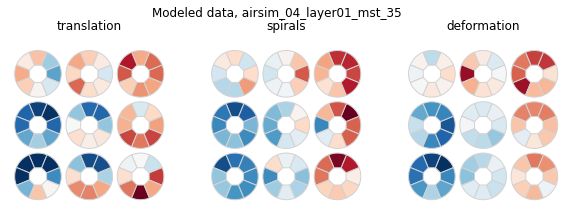

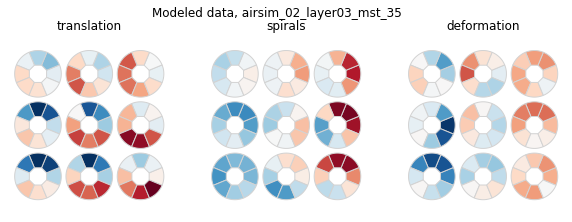

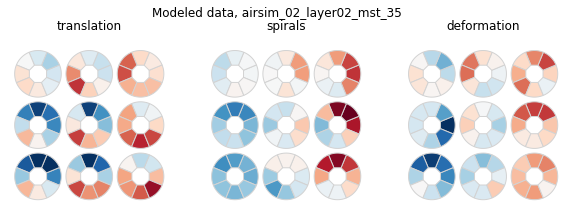

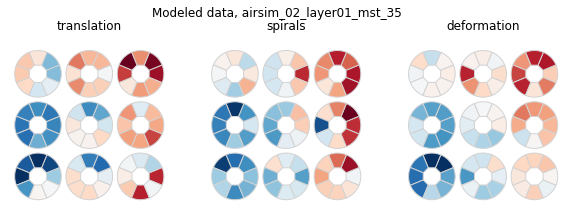

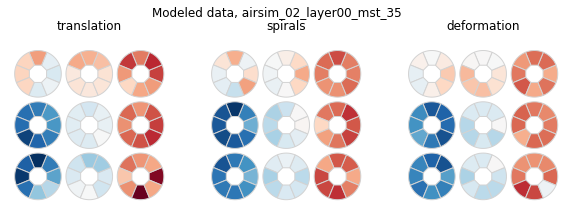

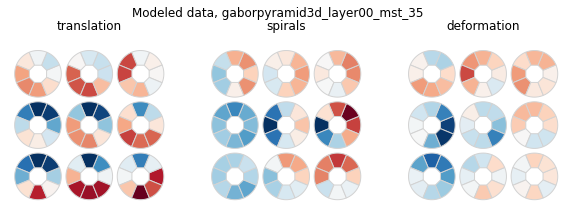

In [130]:
from matplotlib.patches import Patch
import numpy as np
import tables

def draw_tuning_circles(ax, f, rg):
    assert f.shape[-1] == 8
    ri = .4
    ro = 1.0
    cmap=plt.cm.RdBu_r
    norm = plt.Normalize(rg[0], rg[1])
    
    spacing = 2.2
    
    for k in range(f.shape[1]):
        for j in range(f.shape[0]):
            for i in range(8):
                color=cmap(norm(f[k, j, i]))
                theta1 = (i - .5) * 2 * np.pi / 8
                theta2 = (i + .5) * 2 * np.pi / 8
                nsegments = 16
                points = [[spacing * j + ri * np.cos(theta2), -spacing * k + ri * np.sin(theta2)],
                          [spacing * j + ro * np.cos(theta2), -spacing * k + ro * np.sin(theta2)]]
                for n in range(1, nsegments + 1):
                    points.append(
                        [spacing * j + ro * np.cos(theta2 + (theta1 - theta2) * n / nsegments), 
                         -spacing * k + ro * np.sin(theta2 + (theta1 - theta2) * n / nsegments)]
                    )
                points.append([spacing * j + ri * np.cos(theta1), -spacing * k + ri * np.sin(theta1)])
                p = plt.Polygon(points, facecolor=color, edgecolor='lightgray')
                ax.add_patch(p)
                
def draw_supertune(y):
    plt.figure(figsize=(10, 3.3))
    assert y.shape == (3, 3, 3, 8)
    dx = y.max() - np.median(y)
    rg = [np.median(y) - dx, np.median(y) + dx]
    
    titles = ['translation', 'spirals', 'deformation']
    for i in range(3):
        ax = plt.subplot(131 + i)
        draw_tuning_circles(ax, y[:, :, i, :].transpose((1, 0, 2)), rg)
        plt.xlim([-5.6, 1.2])
        plt.ylim([-5.6, 1.2])
        plt.axis('tight')
        plt.axis('equal')
        plt.axis('off')
        plt.title(titles[i])

#draw_tuning_circles(ax, np.tile(np.array([-1, 1, 0, 0, 0, 0, 0, 0]).reshape((1, 1, 8)), [3, 3, 1]), [-1, 1])

table = tables.open_file('/mnt/e/data_derived/packlab-mst/ku259.h5')
y = table.get_node('/Y_report')[:]
#draw_tuning_circles()
#plt.plot(y.reshape((-1, 8)).T)
draw_supertune(y.reshape((3, 3, 3, 8)))
plt.suptitle('Real data')
plt.show()

for k in archives.keys():
    data = archives[k]['optimal_weights']['Y_preds'].cpu().numpy()#.reshape((3, 3, 3, 8))
    data = np.append(data, 0)

    draw_supertune(data.reshape(3, 3, 3, 8))
    plt.suptitle(f'Modeled data, {k}', y = 1.0)
    plt.show()

In [167]:
mat = tables.open_file('/mnt/e/data_derived/packlab-mst/ku259.mat')
Yall = mat.get_node('/Yall_st')[:]
signal_power = 1 / (Yall.shape[0] - 1) * (Yall.shape[0] * Yall.mean(0).var() - Yall.var(1).mean())
response_power = Yall.mean(0).var()

np.sqrt(response_power / signal_power)

1.1655574782756453

In [172]:
table

File(filename=/mnt/e/data_derived/packlab-mst/ku259.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/X_report (Array(2160, 112, 112)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/X_traintune (Array(10842, 112, 112)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/Xidx_report (Array(216, 10)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Xidx_traintune (Array(8999, 10)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Y_report (Array(216, 1)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [170]:
signal_power

3.8531785836762684

In [150]:
y = y.squeeze()
((y - y.mean()) ** 2).mean() / 25

5.2346364883401915

In [162]:
signal_power

5.1500548696844985

In [124]:
plt.suptitle?

Signature: plt.suptitle(t, **kwargs)
Docstring:
Add a centered title to the figure.

Parameters
----------
t : str
    The title text.

x : float, default 0.5
    The x location of the text in figure coordinates.

y : float, default 0.98
    The y location of the text in figure coordinates.

horizontalalignment, ha : {'center', 'left', right'}, default: 'center'
    The horizontal alignment of the text relative to (*x*, *y*).

verticalalignment, va : {'top', 'center', 'bottom', 'baseline'}, default: 'top'
    The vertical alignment of the text relative to (*x*, *y*).

fontsize, size : default: :rc:`figure.titlesize`
    The font size of the text. See `.Text.set_size` for possible
    values.

fontweight, weight : default: :rc:`figure.titleweight`
    The font weight of the text. See `.Text.set_weight` for possible
    values.

Returns
-------
text
    The `.Text` instance of the title.

Other Parameters
----------------
fontproperties : None or dict, optional
    A dict of font propert

In [13]:
import matplotlib.pyplot as plt
plt.plot(archives['airsim_04_layer06_mst_35']['optimal_weights']['Y_preds'].cpu())

In [4]:
import sys
sys.path.append('../')
import fmri_models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from python_dict_wrapper import wrap
import torch
import seaborn as sns


families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'monkeynets',
            'ShallowMonkeyNet_pvc4': 'monkeynets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'monkeynets',
            'dorsalnet': 'monkeynets',
            'airsim_00': 'monkeynets',
            'airsim_02': 'monkeynets',
            'airsim_03': 'monkeynets',
            'airsim_04': 'monkeynets'}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    results.append({'key': k, 
                    'family': fam,
                    'dataset': v['config']['dataset'],
                    'subset': int(v['config']['subset']),
                    'features': v['config']['features'],
                    'layer': layer_num,
                    'report_corr': v['corrs_report']})

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([25, 36, 44])]
#nums.features.unique()#tail(50)
#nums.query('features =="airsim_04"')
#df[df.features == 'airsim_02'].dataset.unique()

In [5]:
df.query('family == "shallow"').groupby(['dataset', 'layer', 'features']).mean() #.mean()

subset  report_corr  subset_overall
dataset layer features                                           
mst     0     gaborpyramid3d    17.5     0.356517            36.0

Setting


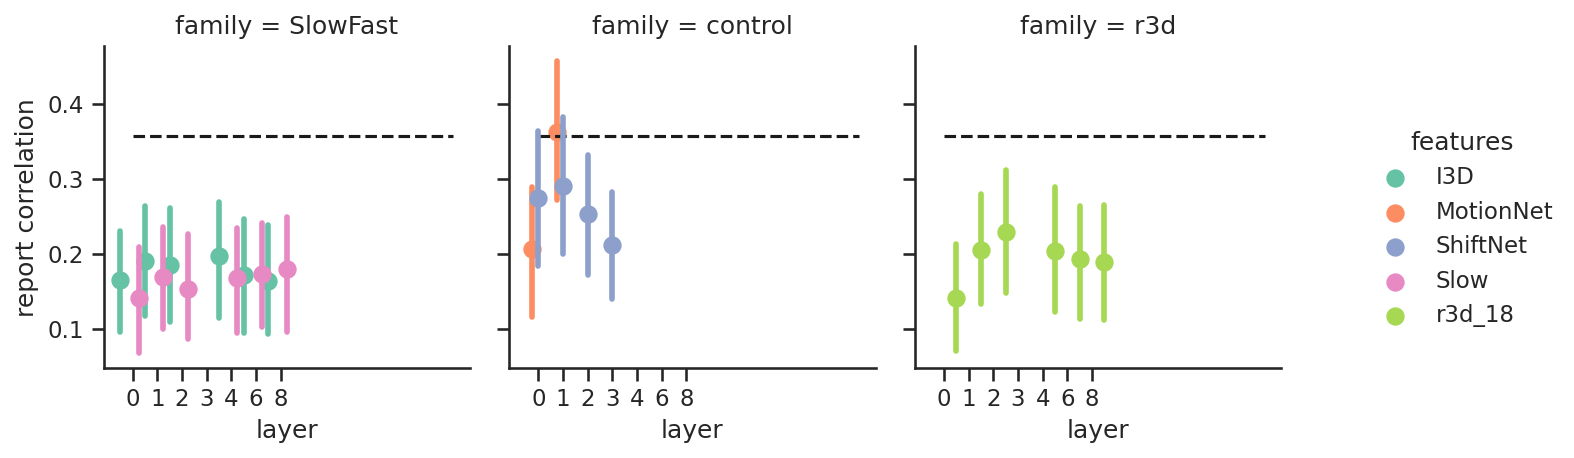

In [6]:
m = df.query('features == "gaborpyramid3d"').report_corr.mean()

def annotate(data, **kws):
    ax = plt.gca()
    
    # Plot the shallow baseline
    ax.plot([0, 13], [m, m], 'k--')
    if data.iloc[0]['family'] == 'control':
        print("Setting")
        ax.set_xlabel('Layer')
        ax.set_ylabel('Report correlation')
    

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_theme(style="ticks")
g = sns.catplot(x='layer', 
             y='report_corr', 
             hue='features',
             col='family', 
             kind='point',
             palette="Set2",
             data=df.query('family != "shallow" and family != "monkeynets"'),
             height=3,
             #legend_outside=False,
             join=False,
             dodge=1,
             margin_titles=True)
g.map_dataframe(annotate, panel=np.arange(3))
g.set_axis_labels("layer", "report correlation")
#g[0]

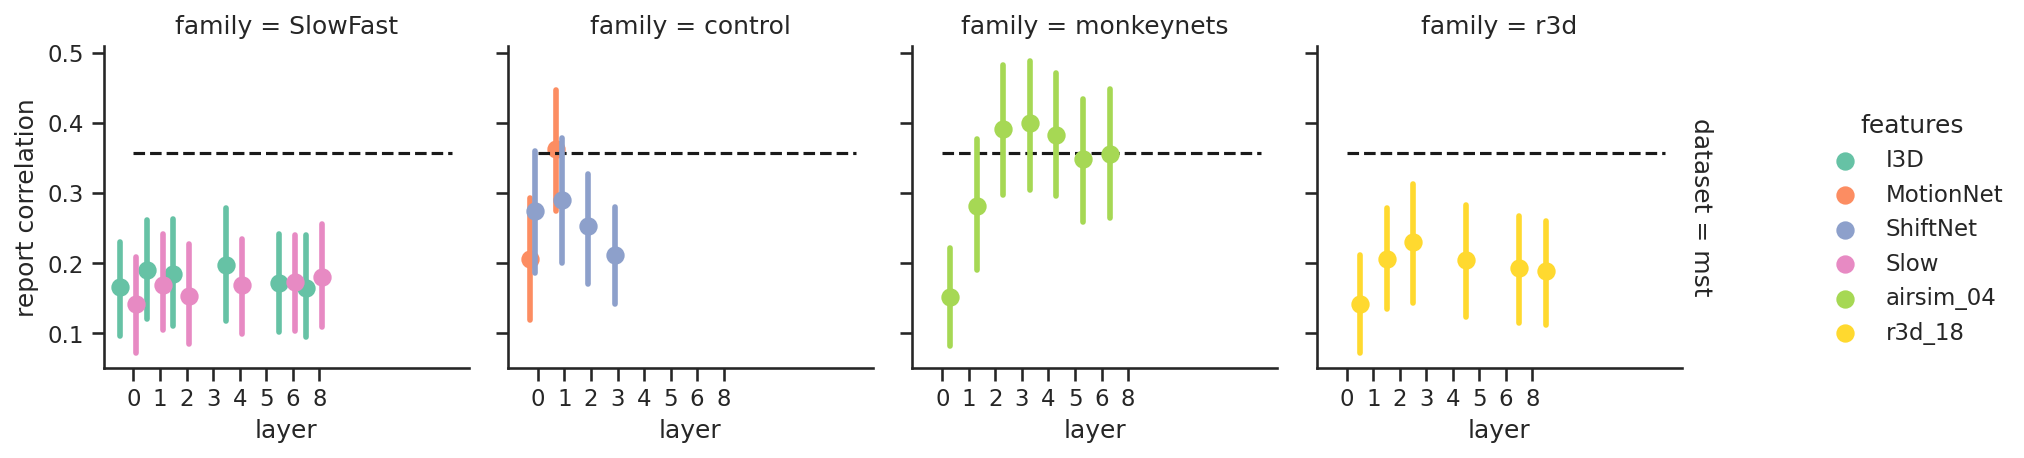

In [7]:
m = df.query('features == "gaborpyramid3d"').groupby('dataset').report_corr.mean()

def annotate(data, **kws):
    ax = plt.gca()
    # Plot the shallow baseline
    baseline = m[data.iloc[0].dataset]
    ax.plot([0, 12], [baseline, baseline], 'k--')

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_theme(style="ticks")
g = sns.catplot(x='layer', 
             y='report_corr', 
             hue='features',
             col='family', 
                row='dataset',
             kind='point',
             palette="Set2",
             data=df.query('family != "shallow" and (features == "airsim_04" or family != "monkeynets")'),
             height=3,
             #legend_outside=False,
             join=False,
             dodge=1,
             margin_titles=True)
g.map_dataframe(annotate, panel=np.arange(3))
g.set_axis_labels("layer", "report correlation")


In [8]:
df['feature_layer'] = df['features'] + '_' + df['layer'].astype(str)
df_ = df.query('dataset == "pvc4"').pivot_table('report_corr', 'subset', 'feature_layer')

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(df_.gaborpyramid3d_motionless_0, df_.gaborpyramid3d_0, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.xlabel('3d gabor pyramid, no motion')
plt.ylabel('3d gabor pyramid, w motion')
plt.axis('square')

plt.subplot(122)
plt.plot(df_.gaborpyramid3d_0, df_.dorsalnet_5, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.xlabel('3d gabor pyramid, w motion')
plt.ylabel('DorsalNet')
plt.axis('square')

plt.suptitle('PVC4 model fits (correlation on report data)')

AttributeError: 'DataFrame' object has no attribute 'gaborpyramid3d_motionless_0'

AttributeError: 'DataFrame' object has no attribute 'gaborpyramid3d_motionless_0'

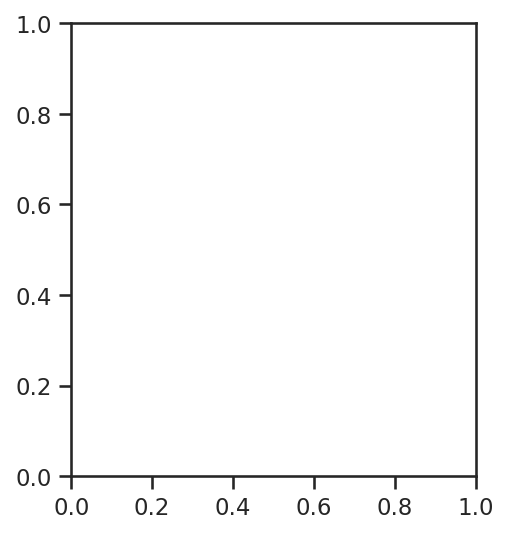

In [9]:
df['feature_layer'] = df['features'] + '_' + df['layer'].astype(str)
df_ = df.query('dataset == "mt2"').pivot_table('report_corr', 'subset', 'feature_layer')

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.plot(df_.gaborpyramid3d_motionless_0, df_.gaborpyramid3d_0, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(df_.gaborpyramid3d_motionless_0[::3], df_.gaborpyramid3d_0[::3], 'r.')
plt.plot([0, 1], [0, 1], 'k-')

plt.xlabel('3d gabor pyramid, no motion')
plt.ylabel('3d gabor pyramid, w motion')
plt.axis('square')

plt.subplot(142)
plt.plot(df_.gaborpyramid3d_0, df_.dorsalnet_5, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(df_.gaborpyramid3d_0[::3], df_.dorsalnet_5[::3], 'r.')
plt.xlabel('3d gabor pyramid, w motion')
plt.ylabel('DorsalNet')
plt.axis('square')

plt.subplot(143)
plt.plot(df_.gaborpyramid3d_0, df_.airsim_04_3, '.')
plt.plot([0, 1], [0, 1], 'k-')
#plt.plot(df_.gaborpyramid3d_0[::3], df_.dorsalnet_5[::3], 'r.')
plt.xlabel('3d gabor pyramid, w motion')
plt.ylabel('Airsim layer 3')
plt.axis('square')

plt.subplot(144)
plt.plot(df_.MotionNet_1, df_.airsim_04_3, '.')
plt.plot([0, 1], [0, 1], 'k-')
#plt.plot(df_.gaborpyramid3d_0[::3], df_.dorsalnet_5[::3], 'r.')
plt.xlabel('Motion Net 1')
plt.ylabel('DorsalNet')
plt.axis('square')

plt.suptitle('MT model fits (correlation on report data)')

In [39]:
df_.columns

Index(['I3D_0', 'I3D_1', 'I3D_2', 'I3D_3', 'I3D_4', 'I3D_5', 'MotionNet_0',
       'MotionNet_1', 'ShallowMonkeyNet_pvc1_0', 'ShallowMonkeyNet_pvc1_1',
       'ShiftNet_0', 'ShiftNet_1', 'ShiftNet_2', 'ShiftNet_3',
       'SlowFast_Fast_0', 'SlowFast_Fast_1', 'SlowFast_Fast_2',
       'SlowFast_Fast_3', 'SlowFast_Fast_4', 'SlowFast_Fast_5',
       'SlowFast_Fast_6', 'V1Net_0', 'V1Net_1', 'V1Net_2', 'V1Net_3',
       'airsim_00_0', 'airsim_00_1', 'airsim_00_2', 'airsim_00_3',
       'airsim_00_4', 'airsim_00_5', 'airsim_00_6', 'dorsalnet_0',
       'dorsalnet_1', 'dorsalnet_2', 'dorsalnet_3', 'dorsalnet_4',
       'dorsalnet_5', 'dorsalnet_6', 'gaborpyramid3d_0',
       'gaborpyramid3d_motionless_0', 'mc3_18_0', 'mc3_18_1', 'mc3_18_10',
       'mc3_18_11', 'mc3_18_12', 'mc3_18_13', 'mc3_18_14', 'mc3_18_15',
       'mc3_18_16', 'mc3_18_2', 'mc3_18_3', 'mc3_18_4', 'mc3_18_5', 'mc3_18_6',
       'mc3_18_7', 'mc3_18_8', 'mc3_18_9', 'r3d_18_0', 'r3d_18_1', 'r3d_18_2',
       'r3d_18_3', 'r3d

In [23]:
df_.gaborpyramid3d_motionless_0[::3]

subset
0     0.187699
3     0.119218
6     0.100751
9     0.118885
12    0.197210
15    0.187876
18    0.253567
21    0.160995
24    0.351813
27    0.284403
30    0.217410
33    0.215996
36    0.119049
39    0.008796
42    0.300288
Name: gaborpyramid3d_motionless_0, dtype: float64

In [73]:
df.query('family == "shallow"').groupby(['dataset', 'layer']).count()

key  family  subset  features  report_corr  layer_overall  \
dataset layer                                                              
mt2     0       43      43      43        43           43             43   
pvc4    0       75      75      75        75           75             75   
        1       50      50      50        50           50             50   

               subset_overall  
dataset layer                  
mt2     0                  43  
pvc4    0                  75  
        1                  50

key      family dataset  subset  \
6     ShallowMonkeyNet_pvc1_layer00_pvc4_0  monkeynets    pvc4       0   
7     ShallowMonkeyNet_pvc1_layer00_pvc4_1  monkeynets    pvc4       1   
8    ShallowMonkeyNet_pvc1_layer00_pvc4_10  monkeynets    pvc4      10   
9    ShallowMonkeyNet_pvc1_layer00_pvc4_11  monkeynets    pvc4      11   
10   ShallowMonkeyNet_pvc1_layer00_pvc4_12  monkeynets    pvc4      12   
..                                     ...         ...     ...     ...   
987           gaborpyramid3d_layer00_v2_95     shallow      v2      95   
988           gaborpyramid3d_layer00_v2_96     shallow      v2      96   
989           gaborpyramid3d_layer00_v2_97     shallow      v2      97   
990           gaborpyramid3d_layer00_v2_98     shallow      v2      98   
991           gaborpyramid3d_layer00_v2_99     shallow      v2      99   

                  features  layer  report_corr  subset_overall  
6    ShallowMonkeyNet_pvc1      0     0.376027              24  
7    ShallowMonkeyNet_pvc1      0     0.333355              24  
8    ShallowMonkeyNet_pvc1      0    -0.013845              24  
9    ShallowMonkeyNet_pvc1      0     0.028829              24  
10   ShallowMonkeyNet_pvc1      0     0.334089              24  
..                     ...    ...          ...             ...  
987         gaborpyramid3d      0     0.025285             120  
988         gaborpyramid3d      0    -0.080322             120  
989         gaborpyramid3d      0     0.130078             120  
990         gaborpyramid3d      0     0.198802             120  
991         gaborpyramid3d      0     0.222245             120  

[426 rows x 8 columns]

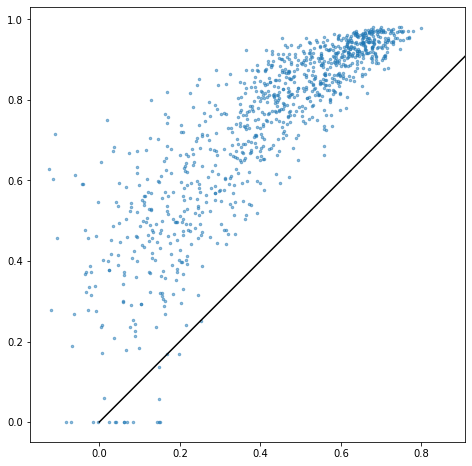

In [31]:
max_r = df.query('key == "Slow_res224_layer10" and area == "v1"').max_r
report_corr = df.query('key == "Slow_res224_layer10" and area == "v1"').report_corr

plt.figure(figsize=(8, 8))
plt.plot(report_corr, max_r, '.', markersize=5, alpha=0.5)
plt.axis('square')
plt.plot([0, 1], [0, 1], 'k-')
plt.xlabel('Report corr')
plt.xlabel('Max corr')

In [41]:
df_2d.relative_r

Series([], Name: relative_r, dtype: float64)

Text(0.5, 1.0, 'Mean prediction normalized correlation')

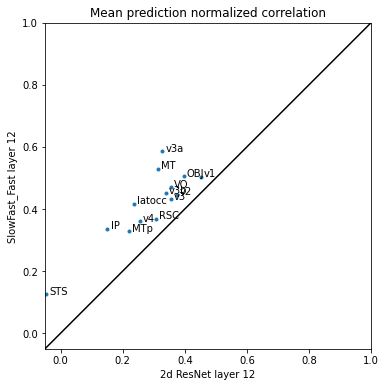

In [45]:
df_3d = df.query('features == "SlowFast_Fast_res224" and layer == 12 and max_r > .2').groupby('area').mean()
df_2d = df.query('features == "resnet18_res224" and layer == 12 and max_r > .2').groupby('area').mean()

plt.figure(figsize=(6, 6))
plt.plot(df_2d.relative_r, df_3d.relative_r, '.')
for i in range(len(df_2d)):
    plt.text(df_2d.relative_r[i]+.01, df_3d.relative_r[i], df_2d.reset_index().area[i])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.axis('square')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.0])

plt.xlabel('2d ResNet layer 12')
plt.ylabel('SlowFast_Fast layer 12')
plt.title('Mean prediction normalized correlation')

Text(0.5, 1.0, 'Mean prediction normalized correlation')

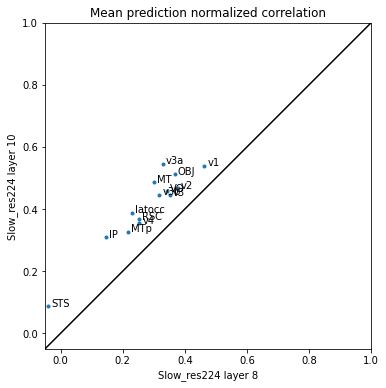

In [50]:
df_3d = df.query('features == "Slow_res224" and layer == 10 and max_r >= .2').groupby('area').mean()
df_2d = df.query('features == "Slow_res224" and layer == 8 and max_r >= .2').groupby('area').mean()

plt.figure(figsize=(6, 6))
plt.plot(df_2d.relative_r, df_3d.relative_r, '.')
for i in range(len(df_2d)):
    plt.text(df_2d.relative_r[i]+.01, df_3d.relative_r[i], df_2d.reset_index().area[i])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.axis('square')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.0])

plt.xlabel('Slow_res224 layer 8')
plt.ylabel('Slow_res224 layer 10')
plt.title('Mean prediction normalized correlation')

In [52]:
df_ = df.query('features == "r3d_18_res112" and max_r > .2')
df_['relative_r_layer'] = df_.apply(lambda x: (x.relative_r, x.layer), axis=1)
df_group = df_.groupby(['voxel']).max()
df_group['best_layer'] = df_group.relative_r_layer.map(lambda x: x[1])

<ipython-input-52-532a77d0b25a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['relative_r_layer'] = df_.apply(lambda x: (x.relative_r, x.layer), axis=1)


In [100]:
df_group

key       features family  layer  report_corr area  \
voxel                                                                         
0      r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.156603   VO   
1      r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.017595   VO   
2      r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.135669   VO   
3      r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.324614   VO   
4      r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.324310   VO   
...                      ...            ...    ...    ...          ...  ...   
8977   r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.107045   v2   
8978   r3d_18_res112_layer16  r3d_18_res112    r3d     16    -0.014350   v2   
8979   r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.031592   v3   
8980   r3d_18_res112_layer16  r3d_18_res112    r3d     16     0.158131   v3   
8981   r3d_18_res112_layer16  r3d_18_res112    r3d     16    -0.011692   v3   

                 report_corr_layer  best_layer  
voxel                                           
0        (0.15660318732261658, 15)          15  
1        (0.017595021054148674, 3)           3  
2        (0.13566863536834717, 15)          15  
3          (0.3246135711669922, 7)           7  
4        (0.32430964708328247, 14)          14  
...                            ...         ...  
8977     (0.10704535245895386, 10)          10  
8978   (-0.014349889941513538, 11)          11  
8979      (0.03159164637327194, 5)           5  
8980      (0.15813085436820984, 8)           8  
8981    (-0.011691959574818611, 0)           0  

[8982 rows x 8 columns]

Text(0.5, 1.0, 'Best layer for each area, r3d')

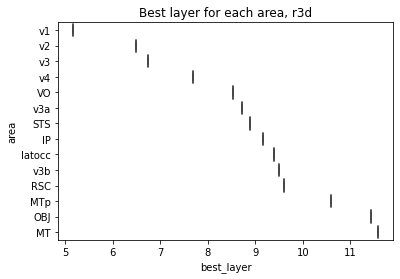

In [53]:
df__ = df_group.query('report_corr > .05').groupby('area').mean().sort_values('best_layer')
sns.boxplot(y='area', 
            x='best_layer', 
            data=df__.reset_index())
plt.title('Best layer for each area, r3d')

<AxesSubplot:xlabel='report_corr', ylabel='key'>

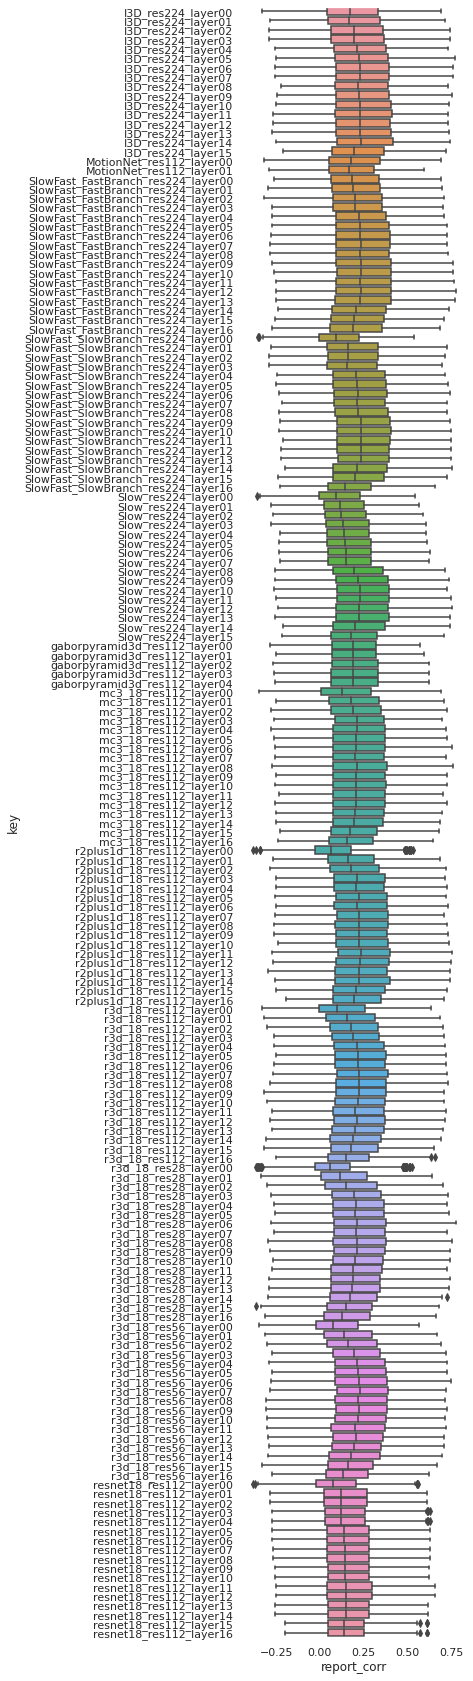

In [39]:
plt.figure(figsize=(4, 30))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.boxplot(y='key', 
            x='report_corr', 
            data=df, ax=plt.gca())

In [19]:
g = sns.catplot(y="key", x="report_corr",
                col="area",
                data=df,
                orient="h", aspect=.6, height=6, palette="Set3",
                kind="box")

(1571850, 3)

In [137]:
import pandas as pd
import seaborn as sns

#plt.figure(figsize=(4, 6))
#sns.boxplot(y='key', x='report_corr', data=df, ax=plt.gca(), hue='area')

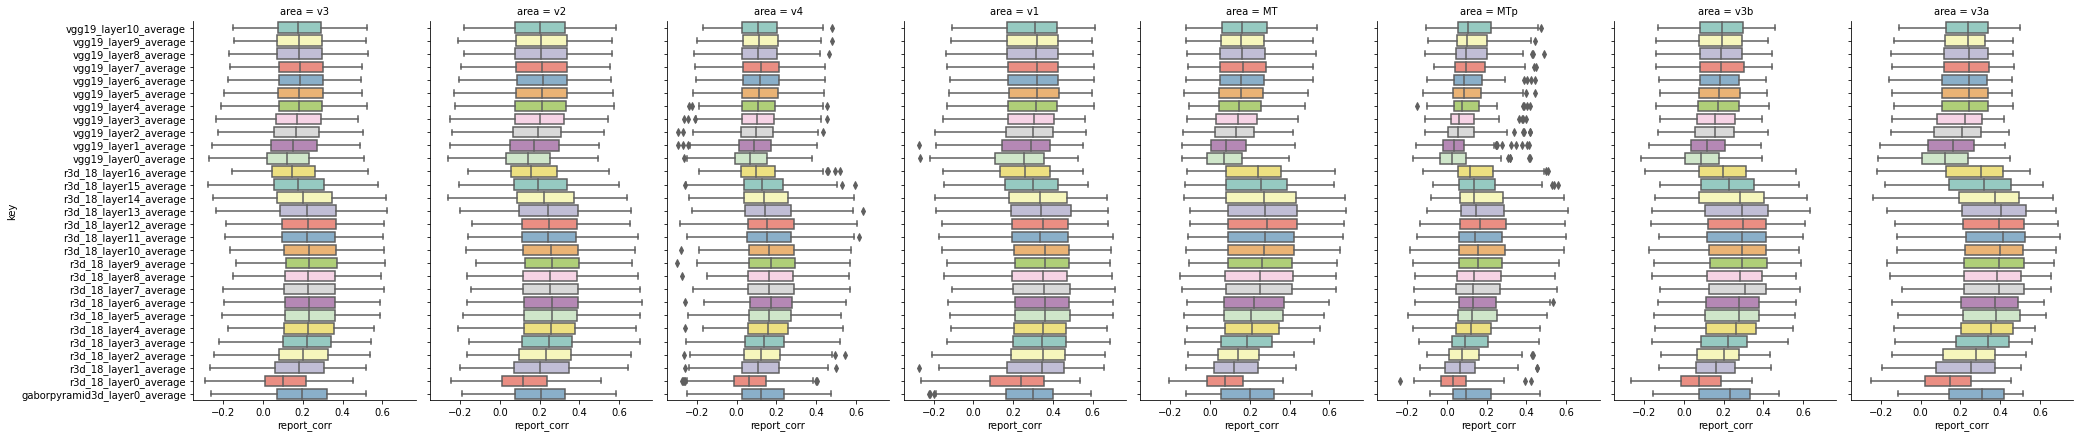

In [138]:
g = sns.catplot(y="key", x="report_corr",
                col="area",
                data=df,
                orient="h", aspect=.6, height=6, palette="Set3",
                kind="box")

In [55]:
from wandb.apis.internal import Api
a = Api()
a.download_urls

r3d_18_layer17_average:0.173
r3d_18_layer16_average:0.199
r3d_18_layer15_average:0.222
r3d_18_layer14_average:0.238
r3d_18_layer13_average:0.241
r3d_18_layer12_average:0.239
r3d_18_layer11_average:0.244
r3d_18_layer10_average:0.249
r3d_18_layer9_average:0.240
r3d_18_layer8_average:0.245
r3d_18_layer7_average:0.240
r3d_18_layer6_average:0.239
r3d_18_layer5_average:0.231
r3d_18_layer4_average:0.219
r3d_18_layer3_average:0.200
r3d_18_layer2_average:0.185
r3d_18_layer1_average:0.110


Text(0.5, 1.0, 'R3D_18 mean report correlation, vim2, map average')

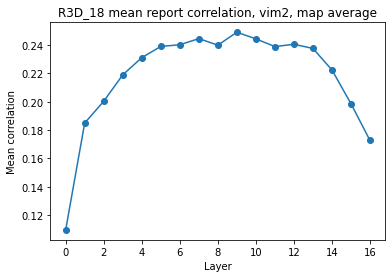

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def mean_from_hist(data):
    x_mean = data['packedBins']['min'] + np.arange(data['packedBins']['count']) * data['packedBins']['size']
    #x_mean = (x_mean[:-1] + x_mean[1:])/2
    the_mean = (x_mean * np.array(data['values'])).sum() / np.array(data['values']).sum()
    return the_mean

ms = []
for key, val in archives.items():
    m = mean_from_hist(val['corrs_report'])
    print(f"{key}:{m:.3f}")
    ms.append(m)
    
plt.plot(np.arange(17), np.array(ms)[::-1], 'o-')
plt.xlabel('Layer')
plt.ylabel('Mean correlation')
plt.title('R3D_18 mean report correlation, vim2, map average')

(-1.1, 1.1)

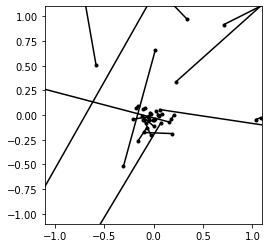

In [171]:
x_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wx'].cpu().numpy()
x_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wx'].cpu().numpy() for x in range(25)]).squeeze()
y_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wy'].cpu().numpy()
y_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wy'].cpu().numpy() for x in range(25)]).squeeze()
#archives['gaborpyramid2d'][0]['config']['learning_rate']
plt.plot(np.stack([x_all_at_once, x_one_by_one], axis=0), 
         np.stack([y_all_at_once, y_one_by_one], axis=0), 'k.-')
plt.axis('square')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

In [166]:
[x_all_at_once, x_one_by_one]

[array([ 0.18238145,  1.0866314 ,  0.00759659, -0.10613997, -0.71515685,
        -1.459469  ,  1.3236212 , -0.05640861, -0.04596966,  0.34030446,
         2.143676  ,  0.709235  , -0.11134848,  0.00410185,  0.02657548,
        -1.3330803 , -1.6518818 , -0.09665827,  0.08307133, -0.0694584 ,
        -0.30469847, -0.17413002, -1.0483379 ,  0.20523083, -0.07756416],
       dtype=float32),
 array([[-9.9157296e-02],
        [ 1.0336617e+00],
        [-1.2724528e-03],
        [-8.6366288e-02],
        [-5.8164388e-01],
        [ 3.1989318e-01],
        [ 2.2802328e-01],
        [-2.0692144e-01],
        [-3.3334795e-02],
        [-1.0469531e+00],
        [ 6.3262224e-02],
        [ 3.3106732e+00],
        [-2.7937867e-02],
        [-1.1491196e-01],
        [ 4.8468444e-02],
        [ 1.5786837e-01],
        [-1.2929194e+00],
        [-3.0077750e-02],
        [ 5.9524819e-02],
        [-1.5480994e-01],
        [ 1.7667795e-02],
        [-1.5860979e-01],
        [ 7.5761326e-02],
        [ 1.8

Tune correlation, all at once, xception2d: 0.1235
Tune correlation, cell-by-cell, xception2d: 0.1751


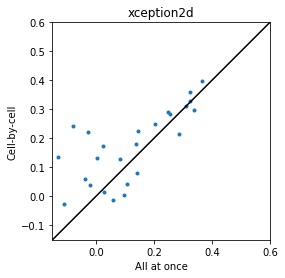

Tune correlation, all at once, gaborpyramid2d: 0.1656
Tune correlation, cell-by-cell, gaborpyramid2d: 0.1860


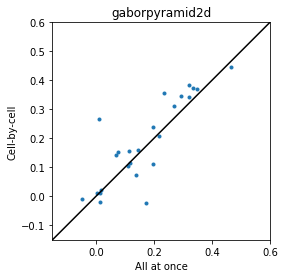

In [143]:
import matplotlib.pyplot as plt

for rep in ['xception2d', 'gaborpyramid2d']:
    tune_corr_all = archives[rep][-1]['tune_corr']
    tune_corr_cell_by_cell = [(k, v['tune_corr']) for k, v in archives[rep].items() if k > -1]
    tune_corr_cell_by_cell = [x[1] for x in sorted(tune_corr_cell_by_cell)]
    plt.plot(tune_corr_all, tune_corr_cell_by_cell, '.')
    plt.plot([-1, 1], [-1, 1], 'k-')
    plt.axis('square')
    plt.xlim((-.15, .6))
    plt.ylim((-.15, .6))
    plt.xlabel('All at once')
    plt.ylabel('Cell-by-cell')
    plt.title(rep)
    print(f"Tune correlation, all at once, {rep}: {np.mean(tune_corr_all):.4f}")
    print(f"Tune correlation, cell-by-cell, {rep}: {np.mean(tune_corr_cell_by_cell):.4f}")
    plt.show()

1
2
3
4
5
6
7
8
9


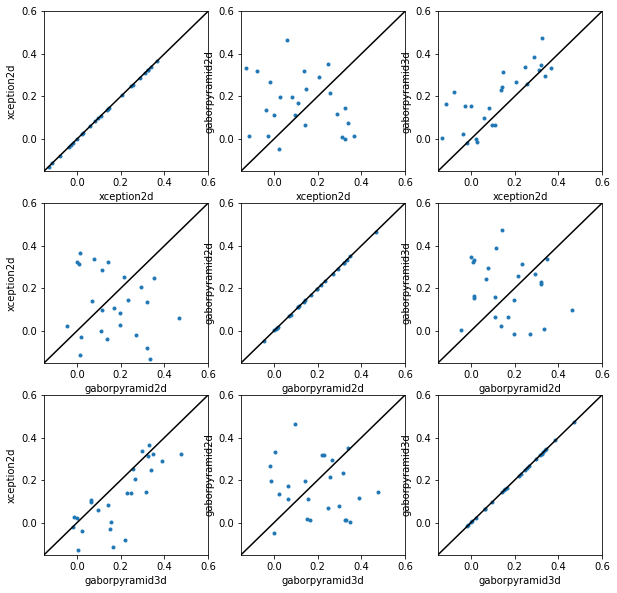

In [187]:
plt.figure(figsize=(10, 10))
reps = ['xception2d', 'gaborpyramid2d', 'gaborpyramid3d']
nrep = 3
for i in range(nrep):
    for j in range(0, nrep):
        rep0 = reps[i]
        rep1 = reps[j]
        plt.subplot(nrep, nrep, 1 + j + i * nrep)
        print(1 + j + i * nrep)
        plt.plot(archives[rep0][-1]['tune_corr'], archives[rep1][-1]['tune_corr'], '.')
        plt.xlabel(rep0)
        plt.ylabel(rep1)
        plt.plot([-1, 1], [-1, 1], 'k-')
        plt.xlim((-.15, .6))
        plt.ylim((-.15, .6))

#for rep in ['xception2d', 'gaborpyramid2d']:
#    tune_corr_all = archives[rep][-1]['tune_corr']

(-0.12, 0.5)

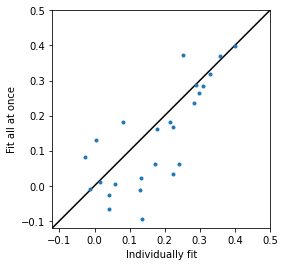

In [112]:
all_at_once = [0.1678023338317871,
               0.37069717049598694,
               0.2859063744544983,
               0.16201408207416534,
               0.1804608851671219,
               0.08193636685609818,
               0.28480473160743713,
               0.18251098692417145,
               0.1291564702987671,
               0.3979525566101074,
               0.26405853033065796,
               0.03389165922999382,
               0.2364319413900375,
               0.0045745414681732655,
               0.02219552919268608,
               -0.06534221768379211,
               0.31926828622817993,
               -0.010949542745947838,
               -0.00940705556422472,
               0.37300461530685425,
               0.01107801217585802,
               -0.094401553273201,
               0.062314119189977646,
               0.06088846176862717,
               -0.027850590646266937]

all_at_once_pretrained = [0.146110400557518,0.32512882351875305,0.2490551471710205,0.13805796205997467,0.2879319489002228,-0.11183082312345503,0.31194233894348145,0.141983300447464,0.0982915461063385,0.36537039279937744,0.3389202356338501,-0.026962850242853165,0.25463470816612244,-0.03682025149464607,0.001990905497223139,0.10854241251945496,0.3230203688144684,0.0827552080154419,0.059587348252534866,0.2049235701560974,0.02760285697877407,-0.12945596873760223,0.02471204660832882,-0.0783606693148613,-0.01916531473398209]
individual = np.array([x['tune_corr'] for x in archives.values()])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.plot(individual[::-1], all_at_once, '.')
plt.xlabel('Individually fit')
plt.ylabel('Fit all at once')
plt.axis('square')
plt.xlim((-0.12, 0.5))
plt.ylim((-0.12, 0.5))

In [114]:
np.mean(all_at_once_pretrained)

0.12351862573996186

In [94]:
import numpy as np

targets = sorted([(v['tune_corr'], v['weights']) for v in archives.values()])[:-17:-1]
ws = []
for _, vals in targets:
    idx = np.argsort(np.random.rand(8))[:4:]
    ws.append(vals['subnet.conv1.weight'][idx, :, :, :].cpu().detach().numpy())

W = np.concatenate(ws, axis=0)
np.save('pretrained/gaborpyramid2d.npy', W)

In [56]:
model_file.mode = 'rb'
model_file

<_io.TextIOWrapper name='D:\\Documents\\brain-scorer\\model.pt' mode='rb' encoding='cp1252'>

In [93]:
len(ws)

15

In [38]:
f = i.file('model.pt')
f.

{'_step': 0, '_runtime': 1, 'tune_corr': 0.04770519211888313, '_timestamp': 1608354193}